# Health Metrics - Data Analysis
## Table of Contents
1. [Setup Packages and Config](#setup-packages-and-config)
2. [Import Data](#import-data)
3. [Clean the Data](#clean-the-data)
   - [Flatten Nested Columns](#flatten-nested-columns)
   - [Convert Dates to DateTime](#convert-dates-to-datetime)
4. [Validate and Save Cleaned Data](#validate-and-save-cleaned-data)
5. [Preparing for Data Analysis](#data-analysis)

# 1. Setup Packages and Config 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Import Data

In [2]:
# Load the JSON data
data = pd.read_json('../original_data/data.json')["data"]

# Extract 'workouts' and 'metrics' DataFrames
wdf = pd.DataFrame(data["workouts"])

metrics_list = []
for metric in data["metrics"]:
    df = pd.DataFrame(metric['data'])
    df['metric'] = metric['name']
    df['units'] = metric['units']
    metrics_list.append(df)

# Combine all metrics into a single DataFrame
mdf = pd.concat(metrics_list, ignore_index=True)

# 3. Clean the Data
## 3.1 Flatten Nested Columns

In [3]:
# Flatten the nested columns in the 'workouts' DataFrame
def extract_qty_column(df, column_name):
    if column_name in df.columns:
        df[f'{column_name}_qty'] = df[column_name].apply(lambda x: x['qty'] if isinstance(x, dict) else x)
    else:
        df[f'{column_name}_qty'] = np.nan
    return df

# Extract the qty from all relevant columns
columns_to_extract = ['activeEnergyBurned', 'distance', 'lapLength', 'intensity', 'humidity', 'temperature']
for column_name in columns_to_extract:
    wdf = extract_qty_column(wdf, column_name)

# Drop the original columns
wdf.drop(columns=columns_to_extract, axis=1, inplace=True)

# Rename 'qty' for clarity
mdf.rename(columns={'qty': 'value'}, inplace=True)

## 3.2 Convert Dates to DateTime


In [4]:
# Convert Dates to DateTime objects
wdf['start'] = pd.to_datetime(wdf['start'], format='%Y-%m-%d %H:%M:%S %z')
wdf['end'] = pd.to_datetime(wdf['end'], format='%Y-%m-%d %H:%M:%S %z')
mdf['date'] = pd.to_datetime(mdf['date'], format='%Y-%m-%d %H:%M:%S %z')
# Count the number of missing values in each column 
print(wdf.isnull().sum())

id                          0
name                        0
start                       0
end                         0
duration                    0
location                  250
activeEnergyBurned_qty      2
distance_qty              237
lapLength_qty             379
intensity_qty              12
humidity_qty              133
temperature_qty           133
dtype: int64


# 4. Validate and Save Cleaned Data

In [5]:
# Validate cleaned data
print(wdf.head()) 
# Save the cleaned data
wdf.to_csv('../cleaned_data/cl_workouts.csv', index=False)
mdf.to_csv('../cleaned_data/cl_metrics.csv', index=False)

                                     id                              name  \
0  1A92CCA1-80B0-4C44-9FA5-DD5A2756478C                     Core Training   
1  BAD3330A-E7F0-4C54-9257-43075838357D  High Intensity Interval Training   
2  00DA3796-BA60-42EB-B28A-74AD67C5C1B5                   Outdoor Cycling   
3  AC234210-6900-45E3-A39F-7EF6505914FE  High Intensity Interval Training   
4  2FE239D9-3311-4C24-8A4B-C876EEAC64FB  High Intensity Interval Training   

                      start                       end    duration location  \
0 2021-03-11 07:03:11-10:00 2021-03-11 07:14:18-10:00  636.608887      NaN   
1 2021-03-24 14:44:10-10:00 2021-03-24 14:51:11-10:00  421.000305      NaN   
2 2021-03-26 03:31:24-10:00 2021-03-26 03:40:00-10:00  515.888359  Outdoor   
3 2021-04-01 11:30:19-10:00 2021-04-01 11:54:35-10:00  948.742759      NaN   
4 2021-04-06 10:28:53-10:00 2021-04-06 10:34:36-10:00    5.955130      NaN   

   activeEnergyBurned_qty  distance_qty  lapLength_qty  intensity_qt

# 5. Data Analysis
#### Find important statistics including count, mean, and standard deviation of each metric.

In [6]:
# Group by metric for visualization/analysis
grouped = mdf.groupby('metric')
print(grouped['value'].describe())

                                   count         mean          std  \
metric                                                               
active_energy                       30.0   423.946000   418.454862   
apple_exercise_time                 19.0    94.473684    58.526697   
apple_stand_hour                    18.0     3.666667     1.455214   
apple_stand_time                    18.0   118.222222    60.821393   
basal_energy_burned                 39.0  1527.811744   495.752660   
blood_oxygen_saturation              5.0    96.300000     1.857418   
cardio_recovery                      4.0    33.290463     0.735433   
environmental_audio_exposure        17.0    72.577678     5.223345   
flights_climbed                     23.0     4.695652     7.080285   
headphone_audio_exposure            77.0    64.576416     6.303185   
heart_rate                          18.0     0.000000     0.000000   
heart_rate_variability               8.0    57.754895    29.475751   
physical_effort     

#### Find and display the correlation matrix. This shows the correlation between any health metrics

In [7]:
# Pivot data for correlation analysis
pivoted_df = mdf.pivot(index='date', columns='metric', values='value')
# Calculate correlations
correlation_matrix = pivoted_df.corr()
print(correlation_matrix)

metric                             active_energy  apple_exercise_time  \
metric                                                                  
active_energy                           1.000000             0.982850   
apple_exercise_time                     0.982850             1.000000   
apple_stand_hour                        0.861588             0.807186   
apple_stand_time                        0.980270             0.976684   
basal_energy_burned                     0.315895             0.113425   
blood_oxygen_saturation                 0.099858             0.003339   
cardio_recovery                         0.979009            -0.266522   
environmental_audio_exposure           -0.537542            -0.509413   
flights_climbed                         0.567648             0.557092   
headphone_audio_exposure                0.292873            -0.216244   
heart_rate                                   NaN                  NaN   
heart_rate_variability                 -0.110354   

#### Find linear regression to help understand and predict the relationship between a dependent var (target) and one or more independent vars (predictors)

Mean Squared Error: 12820.048624570509
Model Coefficients: [0.2315981]


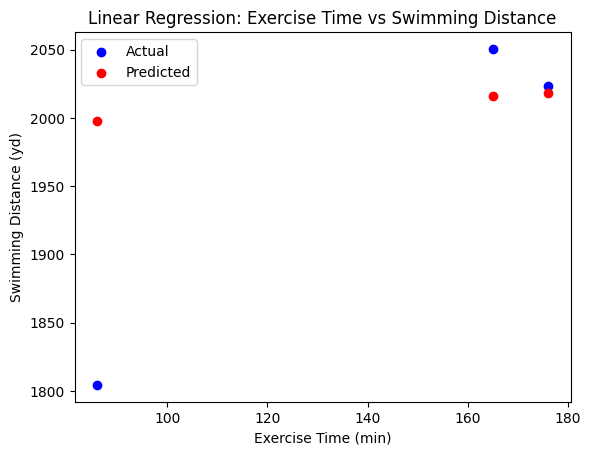

In [8]:
from functions import linear_regression
linear_regression(pivoted_df, 'apple_exercise_time', 'swimming_distance')

#### Analyze trends overtime to understand the shape of the data and predict near-future trends

In [ ]:
from functions import plot_metric_trends

# Plot trends for each metric
for metric, group in mdf.groupby('metric'):
    plot_metric_trends(group, metric)

#### Analyze the correlation between two specific metrics at a time

In [12]:
from functions import analyze_metric_correlation

# Analyze correlation between metrics
analyze_metric_correlation(mdf, "swimming_distance", "resting_heart_rate")
analyze_metric_correlation(mdf, "walking_running_distance", "resting_heart_rate")

Correlation between swimming_distance and resting_heart_rate: 0.9108884745407345
Correlation between walking_running_distance and resting_heart_rate: 0.8206679040515243
